In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [4]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
bad_samples = ['NA19328']
df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## Raw # ICs detected per sample per map haplotype

In [17]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

24934518
8311506


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

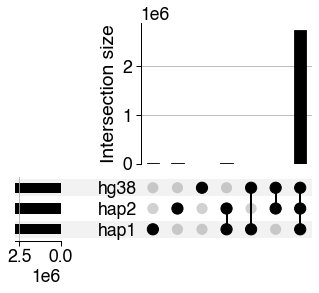

In [23]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(df_crosstab)
upset.plot()

In [24]:
df.head()

,sj_id,junction_novelty,start_site_novelty,end_site_novelty,cell_line_id,map_genome
0,KI270741.1_+_44470_47849,known,known,known,NA12273,hg38
1,KI270741.1_+_48008_52058,known,known,known,NA12273,hg38
2,KI270741.1_+_52137_130639,known,known,known,NA12273,hg38
3,KI270741.1_+_44470_47948,known,known,known,NA12273,hg38
4,GL000224.1_+_102592_105978,known,known,known,NA12273,hg38


In [26]:
# just look at raw counts differences
temp = df[['sj_id', 'cell_line_id', 'map_genome']].groupby(['cell_line_id', 'map_genome']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

# do paired wilcoxon tests for each haplotype
temp = temp.pivot(index='cell_line_id', columns='map_genome', values='n_sj').reset_index()

# Wilcoxon test: hap1 vs hg38. hyp is that hap1 > hg38
stat, pval = st.wilcoxon(temp['hap1'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap1 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")


# Wilcoxon test: hap2 vs hg38. hyp is that hap2 > hg38
stat, pval = st.wilcoxon(temp['hap2'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap2 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")

hap1 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000
hap2 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000


In [27]:
temp['hap1_diff'] = temp['hap1']-temp['hg38']
temp['hap2_diff'] = temp['hap2']-temp['hg38']
temp['hap1_perc_diff'] = (temp['hap1_diff']/temp['hg38'])*100
temp['hap2_perc_diff'] = (temp['hap2_diff']/temp['hg38'])*100

In [28]:
import statistics
thing = temp.hap1_diff.tolist()+temp.hap2_diff.tolist()
statistics.median(thing)

496.0

In [29]:
import statistics
thing = temp.hap1_perc_diff.tolist()+temp.hap2_perc_diff.tolist()
statistics.median(thing)

0.551372618109572

In [30]:
print(len(temp.loc[temp.hap1_diff<0]))
print(len(temp.loc[temp.hap2_diff<0]))

0
0


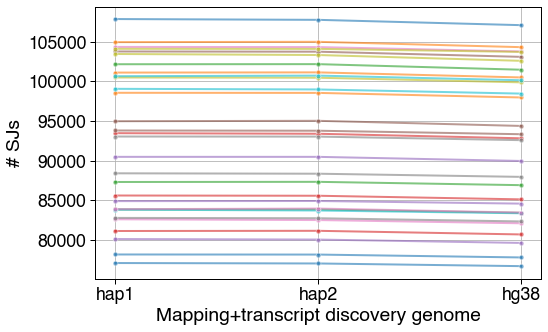

In [31]:
# visualization
init_plot_settings(aspect='square')
temp2 = temp.melt(id_vars=['cell_line_id'], 
                      value_vars=['hap1', 'hap2', 'hg38'], 
                      var_name='map_genome', 
                      value_name='n_sj')
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=temp2, x='map_genome', y='n_sj', hue='cell_line_id', marker='o', palette="tab10",
             linewidth=2, alpha=0.6, legend=False)

plt.ylabel("# SJs")
plt.xlabel("Mapping+transcript discovery genome")
plt.grid(True)
plt.show()

## Are there any differences that are bigger for different populations?

In [32]:
temp = temp.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


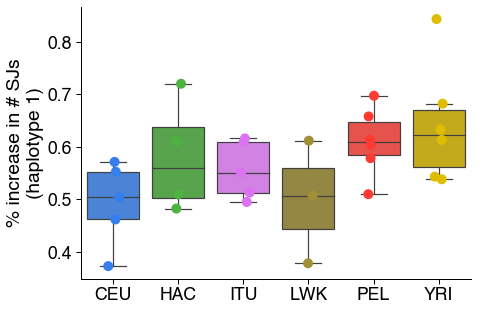

In [43]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap1_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap1_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\n(haplotype 1)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


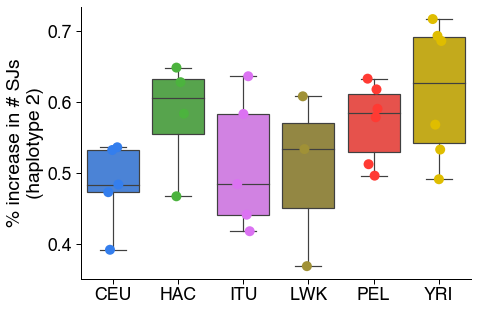

In [35]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='hap2_perc_diff',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='hap2_perc_diff', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\n(haplotype 2)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [41]:
temp2.head()

,population,cell_line_id,variable,value
0,HAC,HG00621,hap1_perc_diff,0.719868
1,PEL,HG01567,hap1_perc_diff,0.603209
2,PEL,HG01928,hap1_perc_diff,0.509488
3,PEL,HG01952,hap1_perc_diff,0.697033
4,PEL,HG01975,hap1_perc_diff,0.578035


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  app.launch_new_instance()


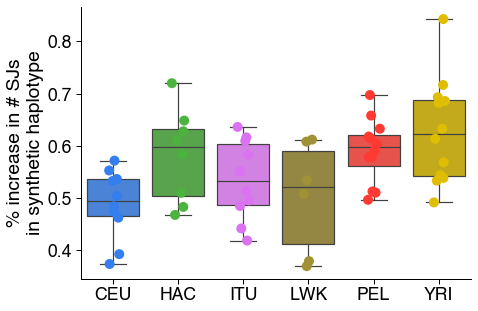

In [42]:
# put the bois together (melt)
temp2 = temp[['hap1_perc_diff', 'hap2_perc_diff', 'population', 'cell_line_id']].melt(id_vars=['population', 'cell_line_id'])
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp2,
            x='population',
            y='value',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='value', data=temp2, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% increase in # SJs\nin synthetic haplotype')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## What do gains look like in terms of different structural categories?

In [194]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

temp['sj_novelty'] = 'Novel SJ: 1 Novel SS'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='known')&\
         (temp.end_site_novelty=='known'), 'sj_novelty'] = 'Novel SJ: Known SS'
temp.loc[(temp.junction_novelty=='known'), 'sj_novelty'] = 'Known'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='novel')&\
         (temp.end_site_novelty=='novel'), 'sj_novelty'] = 'Novel SJ: 2 Novel SS'

24934518
8311506


In [195]:
def get_sj_novelty_colors(cats=None):
    palette = {'Known': "#a23a5f",
               'Novel SJ: 1 Novel SS': "#d7aebc", 
               'Novel SJ: 2 Novel SS': "#e9ced7", 
               'Novel SJ: Known SS': "#c27d97"}
    order = ['Known', 'Novel SJ: Known SS',
             'Novel SJ: 1 Novel SS',
             'Novel SJ: 2 Novel SS']

    palette, order = rm_color_cats(palette, order, cats)
    return palette, order

[Text(0, 0, 'Known'),
 Text(1, 0, 'Novel SJ: Known SS'),
 Text(2, 0, 'Novel SJ: 1 Novel SS'),
 Text(3, 0, 'Novel SJ: 2 Novel SS')]

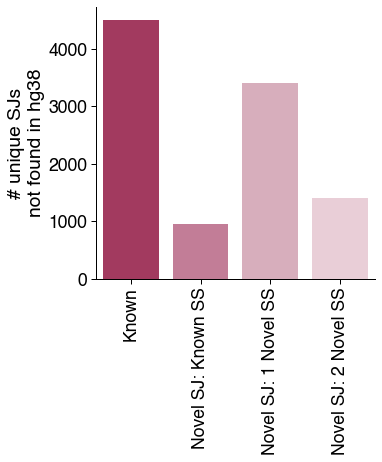

In [196]:
# get just the sjs that are not detected (per sample) in hg38
temp2 = temp.loc[temp.hg38==False]
c_dict, order = get_sj_novelty_colors()
temp2 = temp2[['sj_id', 'sj_novelty']].groupby('sj_novelty').nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)
ax = sns.barplot(temp2, x='sj_novelty',
                 y='n_sj',
                 palette=c_dict,
                 order=order,
                 saturation=1)
ax.set(ylabel='# unique SJs\nnot found in hg38', xlabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


In [197]:
# # only keep uniq sjs
# temp.drop('cell_line_id', axis=1, inplace=True)
# temp = temp.drop_duplicates()
# assert len(temp.loc[temp.sj_id.duplicated()]) == 0

In [198]:
# temp.loc[temp.sj_id.duplicated(skeep=False)].sort_values(by='sj_id')

In [199]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


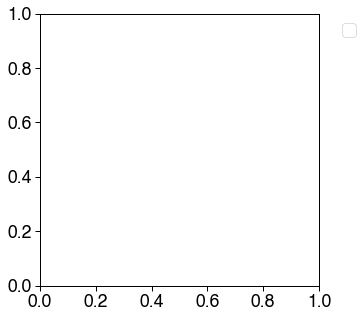

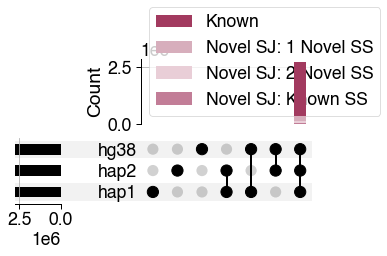

In [200]:
c_dict, order = get_sj_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_novelty_barplot.pdf', dpi=500)

In [201]:
temp_back = temp.copy(deep=True)

In [202]:
temp = temp_back.copy(deep=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


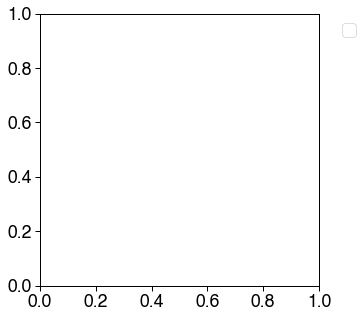

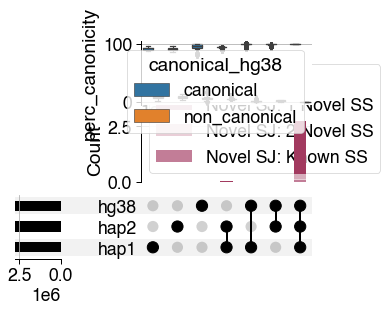

In [203]:
# make a version that has % non-canonical hg38 on top of each thing as a 
# box plots
temp = temp.reset_index() 

file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
temp2 = pd.read_csv(file)
temp2.drop('Unnamed: 0', axis=1, inplace=True)

temp2 = temp2.loc[temp2.sqanti_genome=='hg38']
temp2 = temp2[['canonical', 'sj_id']].drop_duplicates()
temp2.rename({'canonical':'canonical_hg38'}, axis=1, inplace=True)

# make sure no dupe sj_ids
assert len(temp2.loc[temp2.sj_id.duplicated()].index) == 0
temp = temp.merge(temp2, how='left',
                  on='sj_id')

# compute % NC per intersection category / cell line
temp['n_sj_tot'] = temp.groupby(['hap1', 'hap2', 'hg38', 'cell_line_id'])['sj_id'].transform('nunique')
temp['n_sj'] = temp.groupby(['hap1', 'hap2', 'hg38', 'cell_line_id', 'canonical_hg38'])['sj_id'].transform('nunique')
temp['perc_canonicity'] = (temp.n_sj/temp.n_sj_tot)*100
temp.head()

map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

c_dict, order = get_sj_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
upset.add_catplot(
    kind='box',
    hue='canonical_hg38',
    value='perc_canonicity')
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_novelty_barplot_canonicity_boxplot.pdf', dpi=500)

In [204]:
temp = temp.reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


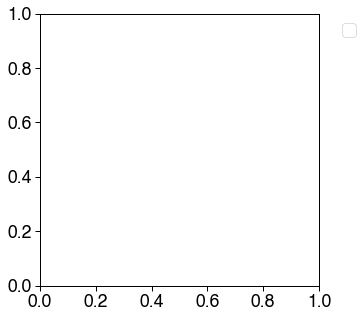

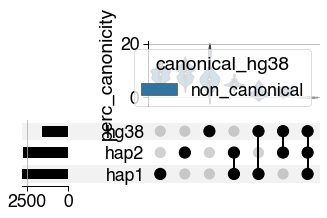

In [205]:
# look at dist of % noncanon.
temp2 = temp[['hap1', 'hap2', 'hg38', 'canonical_hg38', 'perc_canonicity']]
temp2 = temp2.loc[temp2.canonical_hg38=='non_canonical']

map_genomes = ['hg38', 'hap1', 'hap2']
temp2 = temp2.set_index(map_genomes)

c_dict, order = get_sj_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp2, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='violin',
    hue='canonical_hg38',
    value='perc_canonicity')
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_canonicity_violinpllt.pdf', dpi=500)

In [206]:
# remove the intersection of them all 
temp.reset_index(inplace=True)
temp = temp.loc[~(temp[map_genomes].sum(axis=1)==3)]
temp.head()

,index,hg38,hap1,hap2,sj_id,junction_novelty,start_site_novelty,end_site_novelty,cell_line_id,sj_novelty,canonical_hg38,n_sj_tot,n_sj,perc_canonicity
139,139,True,False,True,GL000194.1_-_53893_54677,novel,novel,novel,NA12878,Novel SJ: 2 Novel SS,canonical,139,139,100.000000
154,154,False,False,True,GL000194.1_-_53893_55445,novel,novel,known,HG03729,Novel SJ: 1 Novel SS,canonical,209,188,89.952153
155,155,False,False,True,GL000194.1_-_53893_55445,novel,novel,known,HG04217,Novel SJ: 1 Novel SS,canonical,199,184,92.462312
173,173,True,False,True,GL000194.1_-_54833_55445,known,known,known,NA12878,Known,canonical,139,139,100.000000
187,187,False,False,True,GL000194.1_-_54956_55445,novel,novel,known,HG04217,Novel SJ: 1 Novel SS,canonical,199,184,92.462312


In [207]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)
temp.head()

index                     sj_id junction_novelty  \
hg38  hap1  hap2                                                     
True  False True    139  GL000194.1_-_53893_54677            novel   
False False True    154  GL000194.1_-_53893_55445            novel   
            True    155  GL000194.1_-_53893_55445            novel   
True  False True    173  GL000194.1_-_54833_55445            known   
False False True    187  GL000194.1_-_54956_55445            novel   

                 start_site_novelty end_site_novelty cell_line_id  \
hg38  hap1  hap2                                                    
True  False True              novel            novel      NA12878   
False False True              novel            known      HG03729   
            True              novel            known      HG04217   
True  False True              known            known      NA12878   
False False True              novel            known      HG04217   

                            sj_novelty canonical_hg38  n_sj_tot  n_sj  \
hg38  hap1  hap2                                                        
True  False True  Novel SJ: 2 Novel SS      canonical       139   139   
False False True  Novel SJ: 1 Novel SS      canonical       209   188   
            True  Novel SJ: 1 Novel SS      canonical       199   184   
True  False True                 Known      canonical       139   139   
False False True  Novel SJ: 1 Novel SS      canonical       199   184   

                  perc_canonicity  
hg38  hap1  hap2                   
True  False True       100.000000  
False False True        89.952153  
            True        92.462312  
True  False True       100.000000  
False False True        92.462312

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


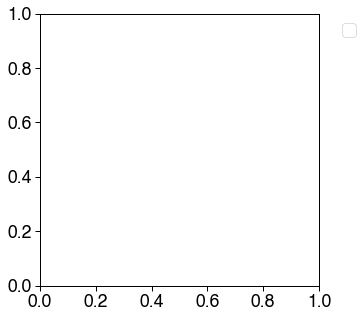

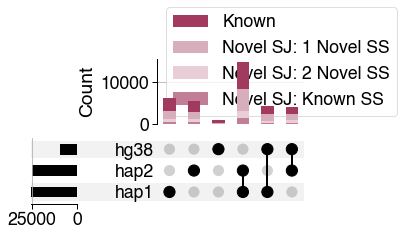

In [208]:
c_dict, order = get_sj_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_undet_sj_novelty_barplot.pdf', dpi=500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


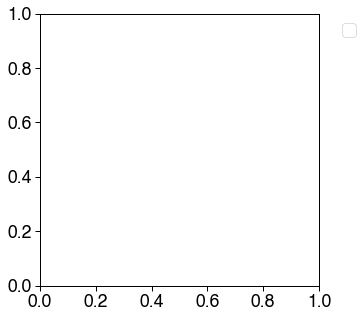

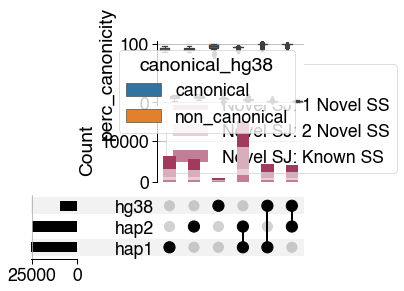

In [209]:
c_dict, order = get_sj_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="sj_novelty", title="Count",
    colors=c_dict)
upset.add_catplot(
    kind='box',
    hue='canonical_hg38',
    value='perc_canonicity')
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_novelty_barplot_canonicity_boxplot.pdf', dpi=500)

## what about when we limit to novel?

In [241]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

temp['sj_novelty'] = 'Novel SJ: 1 Novel SS'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='known')&\
         (temp.end_site_novelty=='known'), 'sj_novelty'] = 'Novel SJ: Known SS'
temp.loc[(temp.junction_novelty=='known'), 'sj_novelty'] = 'Known'
temp.loc[(temp.junction_novelty=='novel')&\
         (temp.start_site_novelty=='novel')&\
         (temp.end_site_novelty=='novel'), 'sj_novelty'] = 'Novel SJ: 2 Novel SS'

24934518
8311506


In [242]:
temp = temp.reset_index() 

file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
temp2 = pd.read_csv(file)
temp2.drop('Unnamed: 0', axis=1, inplace=True)

temp2 = temp2.loc[temp2.sqanti_genome=='hg38']
temp2 = temp2[['canonical', 'sj_id']].drop_duplicates()
temp2.rename({'canonical':'canonical_hg38'}, axis=1, inplace=True)

# make sure no dupe sj_ids
assert len(temp2.loc[temp2.sj_id.duplicated()].index) == 0
temp3 = temp.merge(temp2, how='left',
                  on='sj_id')

In [243]:
# temp3.to_csv('td_hg38_sqanti_master_table.tsv', sep='\t')

In [312]:
df = pd.read_csv('td_hg38_sqanti_master_table.tsv', sep='\t')

In [313]:
# remove novel
df = df.loc[df.junction_novelty!='Known']

In [314]:
df['n_sj_tot'] = df.groupby(['hap1', 'hap2', 'hg38', 'cell_line_id'])['sj_id'].transform('nunique')
df['n_sj'] = df.groupby(['hap1', 'hap2', 'hg38', 'cell_line_id', 'canonical_hg38'])['sj_id'].transform('nunique')
df['perc_canonicity'] = (df.n_sj/df.n_sj_tot)*100

In [315]:
# remove canonical
df = df.loc[df.canonical_hg38=='non_canonical']

In [316]:
df.head()

,Unnamed: 0,index,sj_id,junction_novelty,start_site_novelty,end_site_novelty,cell_line_id,hap1,hap2,hg38,sj_novelty,canonical_hg38,n_sj_tot,n_sj,perc_canonicity
5669,5669,5669,chr10_+_101354229_101374347,novel,known,novel,HG03729,True,False,False,Novel SJ: 1 Novel SS,non_canonical,212,19,8.962264
5670,5670,5670,chr10_+_101354229_101374347,novel,known,novel,HG03732,False,True,False,Novel SJ: 1 Novel SS,non_canonical,123,17,13.821138
5671,5671,5671,chr10_+_101354229_101374347,novel,known,novel,NA19446,True,False,False,Novel SJ: 1 Novel SS,non_canonical,282,27,9.574468
5720,5720,5720,chr10_+_101365217_101374347,novel,novel,novel,NA12778,True,False,False,Novel SJ: 2 Novel SS,non_canonical,200,13,6.500000
10797,10797,10797,chr10_+_110596551_110598138,known,known,known,HG00621,True,True,True,Known,non_canonical,106713,58,0.054351


In [317]:
# get deduped version
df = df[['hap1', 'hap2', 'hg38', 'cell_line_id', 'perc_canonicity', 'n_sj_tot']].drop_duplicates()
assert len(df.loc[df.duplicated(subset=['hap1', 'hap2', 'hg38', 'cell_line_id'], keep=False)].sort_values(['hap1', 'hap2', 'hg38', 'cell_line_id'])) == 0

In [318]:
map_genomes = ['hg38', 'hap1', 'hap2']
df = df.set_index(map_genomes)
df['.'] = ''

In [319]:
df.head()

cell_line_id  perc_canonicity  n_sj_tot .
hg38  hap1  hap2                                           
False True  False      HG03729         8.962264       212  
      False True       HG03732        13.821138       123  
      True  False      NA19446         9.574468       282  
            False      NA12778         6.500000       200  
True  True  True       HG00621         0.054351    106713

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


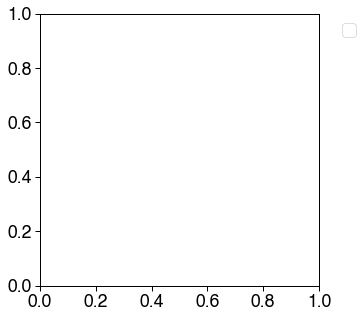

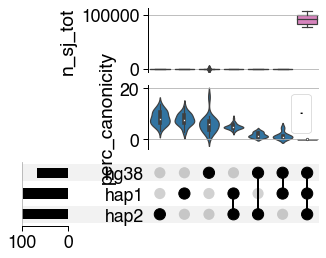

In [320]:
init_plot_settings()
upset = upsetplot.UpSet(df, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='violin',
    hue='.',
    value='perc_canonicity')
upset.add_catplot(
    kind='box',
    value='n_sj_tot')
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.savefig('td_personal_hg38_sj_canonicity_violinpllt.pdf', dpi=500)

In [321]:
# now limit to just the non-all things
df = df.reset_index()
df = df.loc[df[['hg38', 'hap1', 'hap2']].sum(axis=1)<3]

In [322]:
map_genomes = ['hg38', 'hap1', 'hap2']
df = df.set_index(map_genomes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


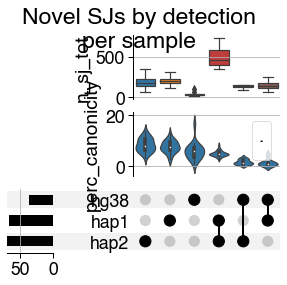

In [326]:
init_plot_settings()
upset = upsetplot.UpSet(df,
                        intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='violin',
    hue='.',
    value='perc_canonicity')
# ax = plt.gca()
ax.set(ylabel='% hg38-non-canonical')
upset.add_catplot(
    kind='box',
    value='n_sj_tot')
# ax = plt.gca()
ax.set(ylabel='# novel SJs')

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
upset.plot()
plt.suptitle('Novel SJs by detection\nper sample')
plt.savefig('td_personal_hg38_sj_canonicity_violinpllt.pdf', dpi=500)

In [332]:
df.reset_index(inplace=True)
df[map_genomes+['n_sj_tot']].groupby(map_genomes).median()

n_sj_tot
hg38  hap1  hap2           
False False True      175.0
      True  False     200.5
            True      454.5
True  False False      29.0
            True      134.5
      True  False     142.0

## Actually wait yeah, we should be getting NO novel NC junctions when sqanti-ing with the same genome that we ranmapping etc on

In [334]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [336]:
# limit just to map <-> sqanti genome matches
df = df.loc[df.map_genome==df.sqanti_genome]

In [337]:
df.head()

,sj_id,splice_motif,canonical,junction_novelty,start_site_novelty,end_site_category,cell_line_id,map_genome,sqanti_genome
0,KI270741.1_+_44470_47849,GTAG,canonical,known,known,known,NA12273,hg38,hg38
1,KI270741.1_+_48008_52058,GTAG,canonical,known,known,known,NA12273,hg38,hg38
2,KI270741.1_+_52137_130639,GTAG,canonical,known,known,known,NA12273,hg38,hg38
3,KI270741.1_+_44470_47948,GTAG,canonical,known,known,known,NA12273,hg38,hg38
4,GL000224.1_+_102592_105978,GTAG,canonical,known,known,known,NA12273,hg38,hg38


In [341]:
df[['cell_line_id', 'sj_id', 'map_genome', 'canonical', 'junction_novelty']].head()
gb_cols = ['cell_line_id', 'map_genome', 'canonical', 'junction_novelty']
keep_cols = gb_cols + ['sj_id']
temp = df[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)
temp.head()

,cell_line_id,map_genome,canonical,junction_novelty,n_sj
0,HG00621,hap1,canonical,known,86590
1,HG00621,hap1,canonical,novel,21217
2,HG00621,hap1,non_canonical,known,67
3,HG00621,hap2,canonical,known,86522
4,HG00621,hap2,canonical,novel,21179


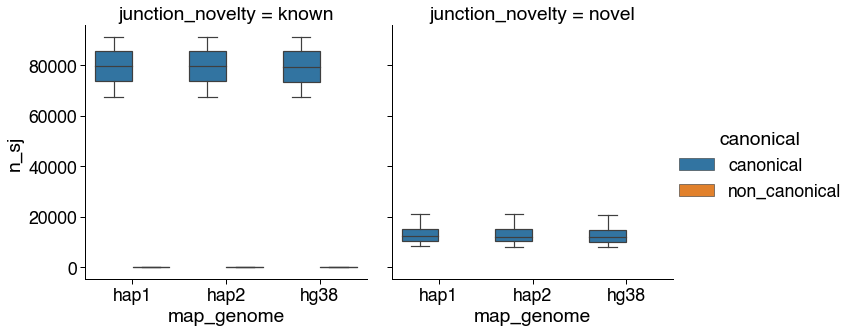

In [342]:
sns.catplot(temp, kind='box',
            x='map_genome', hue='canonical',
            col='junction_novelty',
            y='n_sj')

In [344]:
temp.loc[(temp.junction_novelty=='novel')&(temp.canonical=='non_canonical')]

,cell_line_id,map_genome,canonical,junction_novelty,n_sj
